In [9]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model, load_model  # Aquí se añade load_model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Ajustando seq_len a 26 y num_pred a 13 según el rango de fechas.
Epoch 1/30
12/12 [==============================] - 56s 5s/step - loss: 0.2177 - val_loss: 0.0715
Epoch 2/30
12/12 [==============================] - 54s 5s/step - loss: 0.0972 - val_loss: 0.0702
Epoch 3/30
12/12 [==============================] - 54s 5s/step - loss: 0.0825 - val_loss: 0.0594
Epoch 4/30
12/12 [==============================] - 54s 5s/step - loss: 0.0755 - val_loss: 0.0552
Epoch 5/30
12/12 [==============================] - 52s 4s/step - loss: 0.0701 - val_loss: 0.0492
Epoch 6/30
12/12 [==============================] - 52s 4s/step - loss: 0.0604 - val_loss: 0.0427
Epoch 7/30
12/12 [==============================] - 52s 4s/step - loss: 0.0551 - val_loss: 0.0358
Epoch 8/30
12/12 [==============================] - 52s 4s/step - loss: 0.0496 - val_loss: 0.0305
Epoch 9/30
12/12 [==============================] - 52s 4s/step - loss: 0.0449 - val_loss: 0.0293
Epoch 10/30
12/12 [==============================] - 

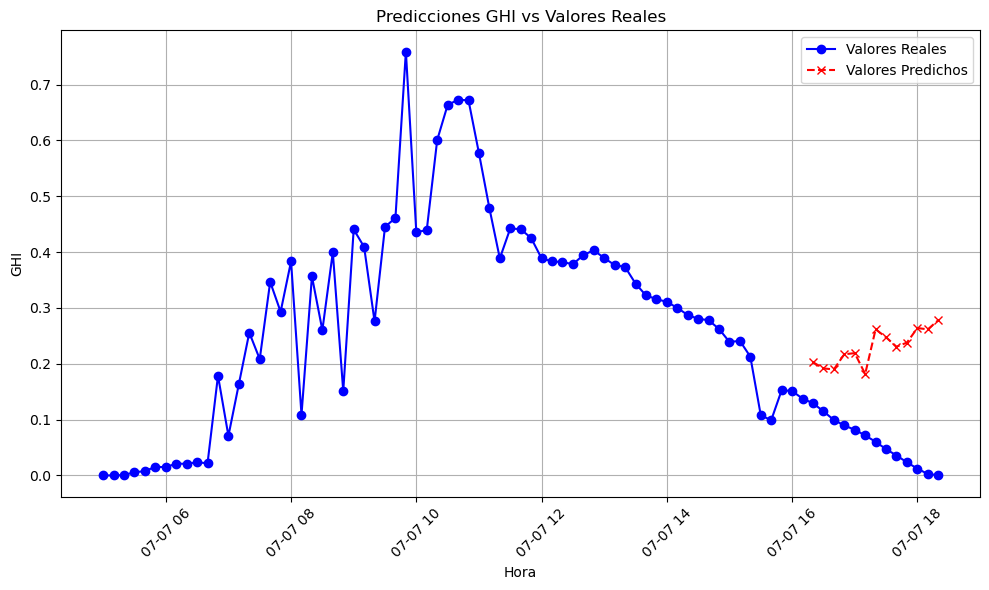

In [10]:
# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def timestamp_to_image_name(timestamp):
    return 'ACMF_' + timestamp.strftime('%Y%m%d_%H%M%S') + '.jpg'

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    
    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_name = timestamp_to_image_name(timestamp)
        image_path = f'{image_folder}/{image_name}'
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionar la imagen a 64x64 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
        else:
            print(f"Imagen no encontrada: {image_path}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    plt.figure(figsize=(10, 6))
    
    # Graficar los valores reales (limitar a la longitud de los predichos si es necesario)
    plt.plot(timestamps[:len(y_real.flatten())], y_real.flatten(), label="Valores Reales", color='blue', marker='o')
    
    # Graficar los valores predichos (limitar a los últimos num_pred valores)
    plt.plot(timestamps[-num_pred:], y_pred.flatten()[-num_pred:], label="Valores Predichos", color='red', linestyle='--', marker='x')
    
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

# --------------------------------------------------------------------------------------------

# Función para ajustar seq_len y num_pred en función del rango de tiempo
def calculate_seq_len_num_pred(start_date, end_date, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    # Calcular la diferencia en minutos entre las fechas de inicio y fin
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60

    # Calcular la cantidad de puntos de datos en el rango de tiempo
    data_points = int(delta_minutes // data_frequency_minutes)

    # Ajustar seq_len en función del tamaño del rango (al menos min_seq_len)
    seq_len = max(min_seq_len, data_points // 3)  # Tomar 1/3 del rango como secuencia

    # Ajustar num_pred para que sea proporcional al rango (al menos min_num_pred)
    num_pred = max(min_num_pred, data_points // 6)  # Tomar 1/6 del rango como predicción

    return seq_len, num_pred

# Entrenamiento del modelo modificado para secuencias usando VGG16
def train_model_vgg16(X_images, y_ghi, seq_len, num_pred):
    # Crear secuencias de entrada y salida
    X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

    # Dividir los datos en entrenamiento y validación
    from sklearn.model_selection import train_test_split
    X_images_seq_train, X_images_seq_val, X_ghi_seq_train, X_ghi_seq_val, y_ghi_pred_train, y_ghi_pred_val = train_test_split(
        X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42)

    # Cargar el modelo VGG16 preentrenado sin la parte superior (sin capas densas)
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Congelar las capas del modelo VGG16 para que no se entrenen
    vgg16_base.trainable = False

    # Aplicar VGG16 a cada imagen de la secuencia usando TimeDistributed
    image_input = Input(shape=(seq_len, 64, 64, 3))  # Input de secuencias de imágenes de 64x64
    vgg16_features = TimeDistributed(vgg16_base)(image_input)

    # Aplanar las características obtenidas de VGG16
    vgg16_features = TimeDistributed(Flatten())(vgg16_features)

    # Entrada de los valores GHI
    numeric_input = Input(shape=(seq_len, 1))
    concat = Concatenate()([vgg16_features, numeric_input])

    # Pasar las características concatenadas a LSTM
    lstm_out = LSTM(64, return_sequences=False)(concat)

    # Agregar Dropout para regularización
    lstm_out = Dropout(0.3)(lstm_out)

    # Capa densa para hacer la predicción de GHI (10 valores futuros)
    output = Dense(num_pred)(lstm_out)

    # Definir el modelo completo
    model = Model([image_input, numeric_input], output)

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse')

    # Entrenar el modelo
    history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train,
                        validation_data=([X_images_seq_val, X_ghi_seq_val], y_ghi_pred_val),
                        epochs=30, batch_size=32)

    return model, history

# --------------------------------------------------------------------------------------------

# Cargar el Dataframe
df = pd.read_pickle('df_GHI.plk')

# 1. Definir el rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-07-01 05:00:00'  # Fecha de inicio de entrenamiento
fecha_fin_entrenamiento = '2023-07-06 18:20:00'  # Fecha de fin de entrenamiento

# Filtrar el DataFrame por el rango de entrenamiento
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Asegurar que la columna Timestamp sea de tipo datetime
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI para el entrenamiento
image_folder = 'Images/ACMF'
X_images_train, y_ghi_train, scaler_train = load_images_and_ghi(df_entrenamiento, image_folder)

# 2. Definir el rango de fechas para la predicción
fecha_inicio_prediccion = '2023-07-07 05:00:00'  # Nueva fecha de inicio para la predicción
fecha_fin_prediccion = '2023-07-07 18:20:00'  # Nueva fecha de fin para la predicción

# Filtrar el DataFrame por el rango de predicción
df_prediccion = df[(df['Timestamp'] >= fecha_inicio_prediccion) & (df['Timestamp'] <= fecha_fin_prediccion)]

# Cargar imágenes y valores GHI para la predicción
X_images_test, y_ghi_test, scaler_test = load_images_and_ghi(df_prediccion, image_folder)

# Calcular automáticamente seq_len y num_pred en función del rango de fechas de predicción
start_date = pd.to_datetime(fecha_inicio_prediccion)
end_date = pd.to_datetime(fecha_fin_prediccion)
seq_len, num_pred = calculate_seq_len_num_pred(start_date, end_date)

print(f"Ajustando seq_len a {seq_len} y num_pred a {num_pred} según el rango de fechas.")

# Verificar si hay suficientes datos para crear secuencias de entrenamiento
if len(X_images_train) > seq_len:
    # Entrenar el modelo con los datos de entrenamiento
    model, history = train_model_vgg16(X_images_train, y_ghi_train, seq_len, num_pred)

    # Verificar si hay suficientes datos para crear secuencias de predicción
    if len(X_images_test) > seq_len:
        # Crear secuencias de entrada y salida con las nuevas imágenes y valores GHI
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        if len(X_images_seq_test) > 0:
            # Hacer predicciones con el modelo en las nuevas secuencias
            y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])

            # Invertir la normalización de los valores predichos y reales
            y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
            y_ghi_test_inversed = scaler_test.inverse_transform(y_ghi_test.reshape(-1, 1))

            # Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
            timestamps_test = pd.date_range(start=fecha_inicio_prediccion, periods=len(y_ghi_test_inversed), freq='10T')

            # Graficar los resultados predichos y reales para las nuevas fechas
            plot_real_vs_predicted(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales")
        else:
            print("No hay suficientes secuencias para generar predicciones.")
else:
    print("No hay suficientes imágenes en el rango de fechas seleccionado para el entrenamiento.")


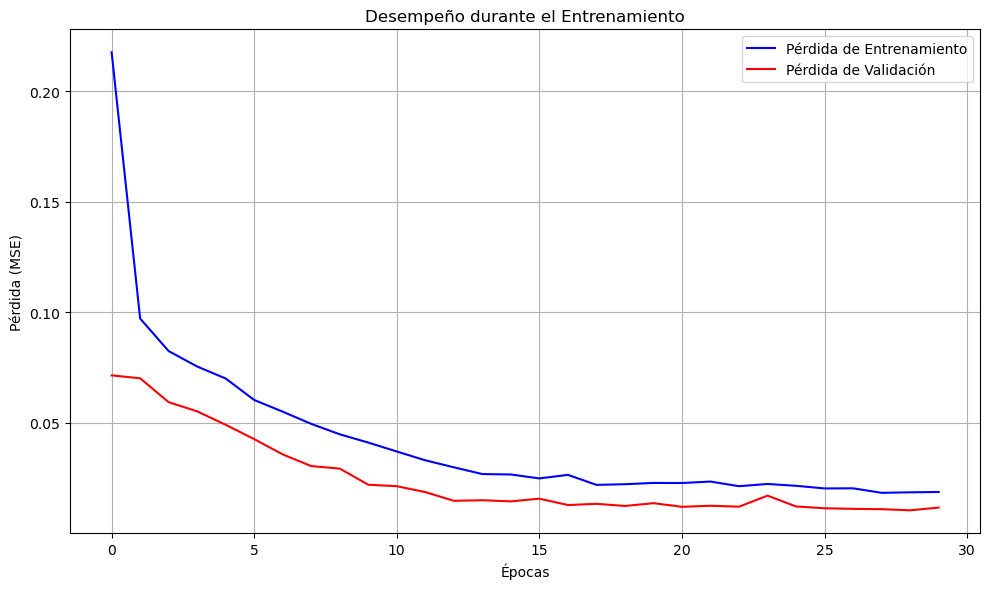

In [19]:
# Función para graficar el desempeño durante el entrenamiento
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    
    # Graficar la pérdida (loss) en entrenamiento y validación
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento', color='blue')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación', color='red')
    
    plt.title('Desempeño durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

# Después de entrenar el modelo, graficar el historial del entrenamiento
plot_training_history(history)

In [11]:
model.save('CNN_LSTM_VGG16.h5')

/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
df = pd.read_pickle('df_GHI.plk')

In [13]:
from datetime import timedelta

# Función para ajustar seq_len y num_pred dinámicamente según el rango de fechas
def calculate_seq_len_num_pred_dynamic(start_date, end_date, fixed_seq_len=26, fixed_num_pred=10, data_frequency_minutes=10, min_seq_len=12, min_num_pred=5):
    # Calcular la diferencia en minutos entre las fechas de inicio y fin
    delta = end_date - start_date
    delta_minutes = delta.total_seconds() / 60

    # Verificar si el rango de tiempo es menor a 6 horas (360 minutos)
    if delta_minutes < 360:
        # Si el rango es mayor a 2 horas pero menor a 6, generamos una advertencia
        if delta_minutes > 120:
            raise ValueError("El rango de fechas seleccionado es mayor a 2 horas pero menor a 6 horas. Para resultados óptimos, elige un rango mayor a 6 horas.")
        else:
            # Si es menor a 2 horas, generar error directamente
            raise ValueError("El rango de fechas seleccionado es menor a 2 horas. Se requiere un rango de al menos 2 horas.")
    
    # Calcular la cantidad de puntos de datos en el rango de tiempo
    data_points = int(delta_minutes // data_frequency_minutes)

    # Verificar si hay suficientes datos para los valores fijos
    if data_points < (fixed_seq_len + fixed_num_pred):
        # Ajustar dinámicamente seq_len y num_pred en función de los datos disponibles
        seq_len = max(min_seq_len, data_points // 2)  # La mitad de los puntos disponibles como secuencia
        num_pred = max(min_num_pred, data_points - seq_len)  # El resto para predicciones

        print(f"El rango de fechas es demasiado corto. Ajustando seq_len a {seq_len} y num_pred a {num_pred}.")
    else:
        # Usar los valores fijos si hay suficientes datos
        seq_len = fixed_seq_len
        num_pred = fixed_num_pred

    return seq_len, num_pred

# Módulo para probar el modelo con nuevas fechas
def test_model_with_new_dates(model_path, df, fecha_inicio, fecha_fin, image_folder):
    # Cargar el modelo previamente entrenado
    model = load_model(model_path)

    # Filtrar el DataFrame por el rango de predicción
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Asegurar que la columna Timestamp sea de tipo datetime
    df_prediccion = df[(df['Timestamp'] >= fecha_inicio) & (df['Timestamp'] <= fecha_fin)]

    # Cargar imágenes y valores GHI para la predicción
    X_images_test, y_ghi_test, scaler_test = load_images_and_ghi(df_prediccion, image_folder)

    # Calcular seq_len y num_pred dinámicamente
    start_date = pd.to_datetime(fecha_inicio)
    end_date = pd.to_datetime(fecha_fin)
    seq_len, num_pred = calculate_seq_len_num_pred_dynamic(start_date, end_date, fixed_seq_len=26, fixed_num_pred=10)

    print(f"Ajustando seq_len a {seq_len} y num_pred a {num_pred} según el rango de fechas.")

    # Verificar si hay suficientes datos para crear secuencias
    if len(X_images_test) > seq_len:
        # Crear secuencias de entrada y salida con las imágenes y valores GHI
        X_images_seq_test, X_ghi_seq_test, y_ghi_pred_test = create_sequences(X_images_test, y_ghi_test, seq_len, num_pred)

        if len(X_images_seq_test) > 0:
            # Hacer predicciones con el modelo en las nuevas secuencias
            y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])

            # Verificar el tamaño de la matriz de predicciones antes de continuar
            print(f"Tamaño de predicciones: {y_ghi_pred_test.shape}")

            # Asegurar que la predicción pueda ser reconfigurada correctamente
            y_ghi_pred_test_inversed = scaler_test.inverse_transform(y_ghi_pred_test.flatten().reshape(-1, 1)).flatten()

            # Invertir la normalización de los valores reales
            y_ghi_test_inversed = scaler_test.inverse_transform(y_ghi_test.reshape(-1, 1)).flatten()

            # Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
            timestamps_test = pd.date_range(start=fecha_inicio, periods=len(y_ghi_test_inversed), freq='10T')

            # Graficar los resultados predichos y reales para las nuevas fechas
            plot_real_vs_predicted(timestamps_test, y_ghi_test_inversed, y_ghi_pred_test_inversed, title="Predicciones GHI vs Valores Reales")
        else:
            print("No hay suficientes secuencias para generar predicciones.")
    else:
        print("No hay suficientes imágenes en el rango de fechas seleccionado.")


Ajustando seq_len a 26 y num_pred a 10 según el rango de fechas.
1/1 [==============================] - 0s 366ms/step
Tamaño de predicciones: (1, 13)


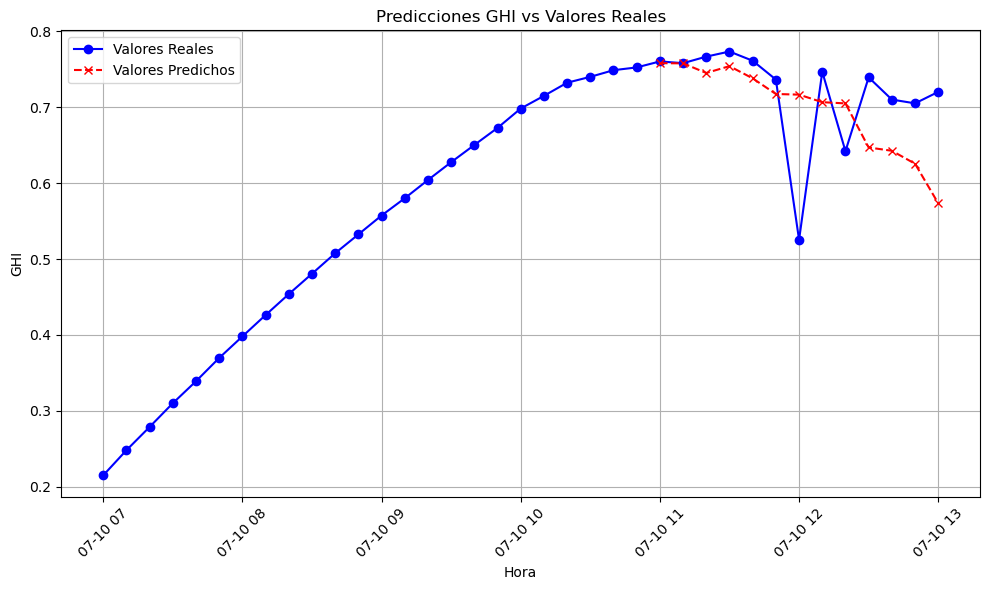

In [14]:
image_folder = 'Images/ACMF'  # Carpeta donde se encuentran las imágenes
model_path = 'CNN_LSTM_VGG16.h5'  # Ruta del modelo entrenado (en este caso en la misma carpeta)

# Definir las nuevas fechas para probar el modelo
fecha_inicio = '2023-07-10 07:00:00'
fecha_fin = '2023-07-10 13:00:00'

# Probar el modelo con el nuevo rango de fechas
test_model_with_new_dates(model_path, df, fecha_inicio, fecha_fin, image_folder)


Ajustando seq_len a 26 y num_pred a 10 según el rango de fechas.
1/1 [==============================] - 2s 2s/step
Tamaño de predicciones: (13, 13)


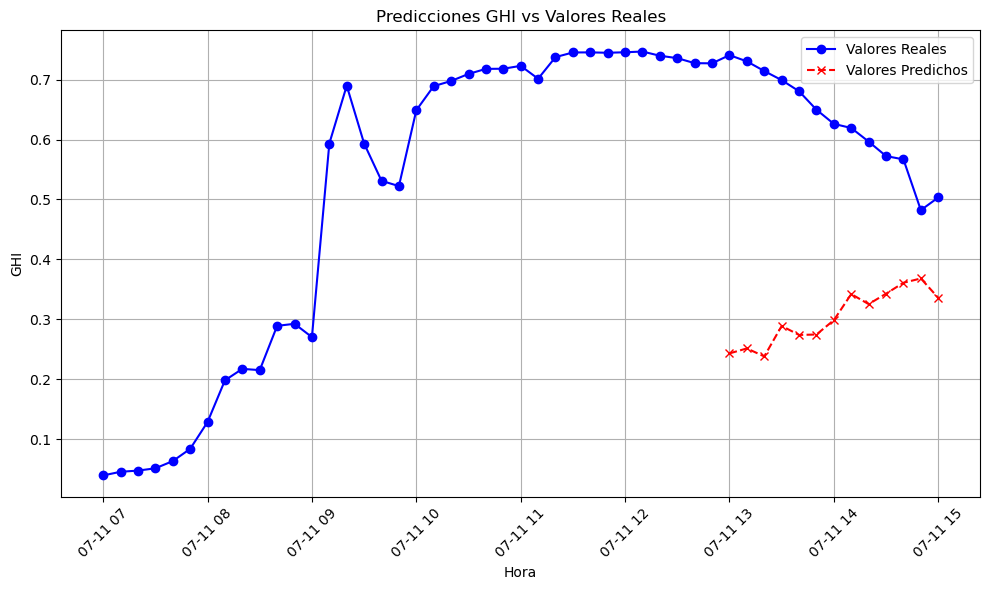

In [16]:
# Definir las nuevas fechas para probar el modelo
fecha_inicio = '2023-07-11 07:00:00'
fecha_fin = '2023-07-11 15:00:00'

# Probar el modelo con el nuevo rango de fechas
test_model_with_new_dates(model_path, df, fecha_inicio, fecha_fin, image_folder)


Imagen no encontrada: Images/ACMF/ACMF_20230712_183000.jpg
Ajustando seq_len a 26 y num_pred a 10 según el rango de fechas.


[ WARN:0@1655.062] global loadsave.cpp:248 findDecoder imread_('Images/ACMF/ACMF_20230712_183000.jpg'): can't open/read file: check file path/integrity


1/1 [==============================] - 2s 2s/step
Tamaño de predicciones: (15, 13)


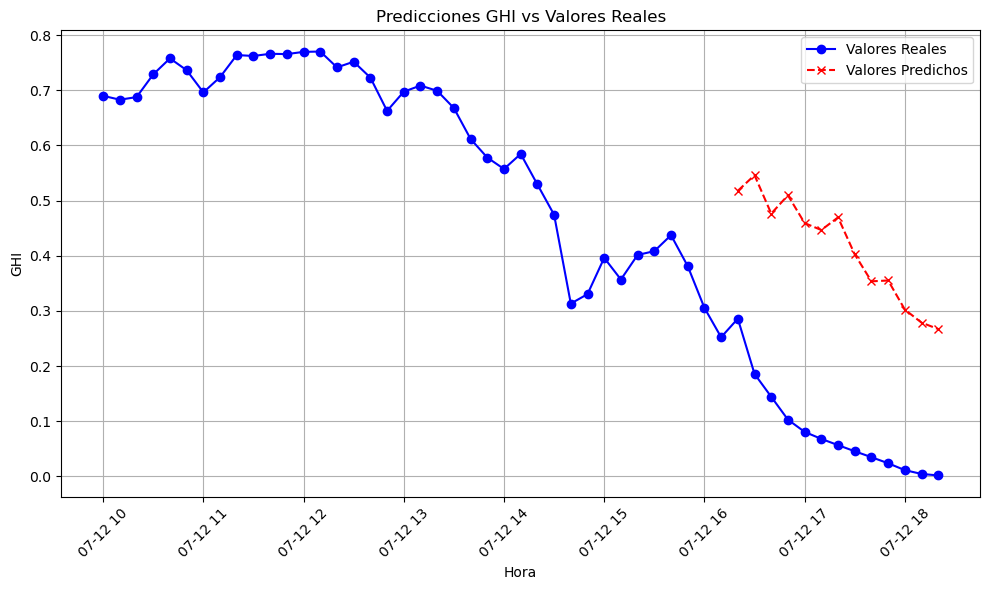

In [17]:
# Definir las nuevas fechas para probar el modelo
fecha_inicio = '2023-07-12 10:00:00'
fecha_fin = '2023-07-12 19:00:00'

# Probar el modelo con el nuevo rango de fechas
test_model_with_new_dates(model_path, df, fecha_inicio, fecha_fin, image_folder)


Ajustando seq_len a 26 y num_pred a 10 según el rango de fechas.
4/4 [==============================] - 14s 3s/step
Tamaño de predicciones: (121, 13)


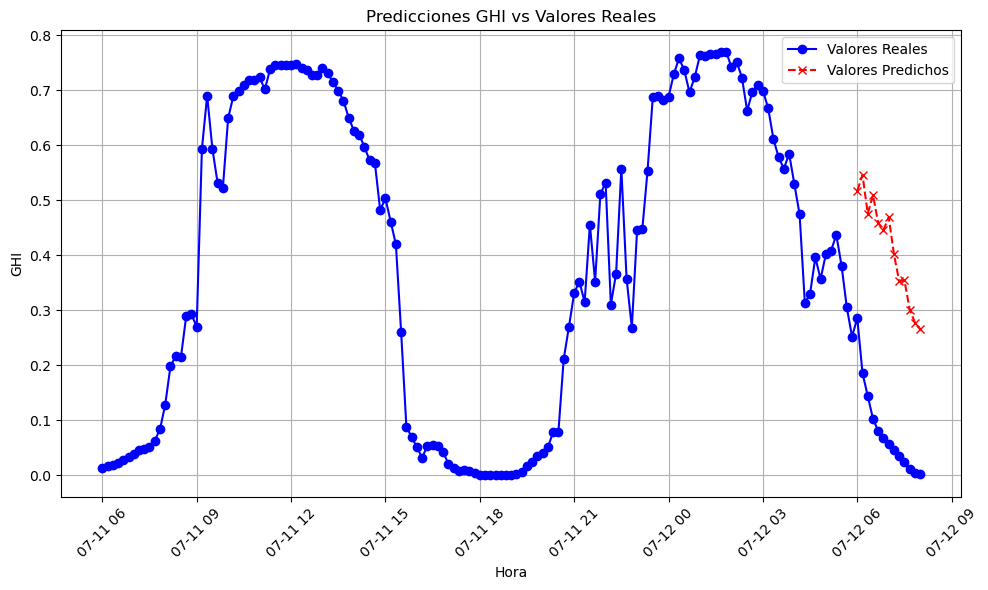

In [18]:
# Definir las nuevas fechas para probar el modelo
fecha_inicio = '2023-07-11 06:00:00'
fecha_fin = '2023-07-12 18:20:00'

# Probar el modelo con el nuevo rango de fechas
test_model_with_new_dates(model_path, df, fecha_inicio, fecha_fin, image_folder)
